In [41]:
!pip install matplotlib

In [42]:
import pandas as pd
import os
from pathlib import Path
import re
import sqlite3
import requests
from functools import reduce
import matplotlib.pyplot as plt
import geopandas as gpd

pd.set_option('display.max_columns', None)

In [43]:
stasiun_mapping = {
    'DKI1': 'Jakarta Pusat',
    'DKI2': 'Jakarta Utara',
    'DKI3': 'Jakarta Selatan',
    'DKI4': 'Jakarta Timur',
    'DKI5': 'Jakarta Barat'
}

In [44]:
# Define column mapping to match data.md convention
column_mapping = {
    'pm10': 'pm_sepuluh',
    'so2': 'sulfur_dioksida',
    'co': 'karbon_monoksida',
    'o3': 'ozon',
    'no2': 'nitrogen_dioksida',
    'critical': 'parameter_pencemar_kritis',
    'categori': 'kategori',
    'lokasi_spku': 'stasiun'
}

# Define column order to match data.md
column_order = [
    'periode_data', 'tanggal', 'stasiun', 'pm_sepuluh',
    'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida',
    'max', 'parameter_pencemar_kritis', 'kategori'
]


final_year = 2019

# Define the folder path and years to combine
ispu_folder = Path("data/ISPU")
years_to_combine = [i for i in range(2015, final_year + 1, 1)]

# List to store dataframes
dfs = []

# Load and standardize files that contain the desired years
for file_path in ispu_folder.glob("*.csv"):
    # Check if any of the desired years is in the filename
    for year in years_to_combine:
        if str(year) in file_path.name:
            df_temp = pd.read_csv(file_path)
            
            print(f"Loaded: {file_path.name}")
            print(f"  Original columns: {list(df_temp.columns)}")
            
            # Rename columns to match convention
            df_temp = df_temp.rename(columns=column_mapping)
            
            # Add missing columns with None
            for col in column_order:
                if col not in df_temp.columns:
                    df_temp[col] = None
            
            # Reorder columns to match data.md
            df_temp = df_temp[column_order]
            
            print(f"  Standardized to: {list(df_temp.columns)}")
            print(f"  Rows: {len(df_temp)}\n")
            
            dfs.append(df_temp)
            break

print(f"Total files loaded: {len(dfs)}")

# Combine all dataframes
df_combined = pd.concat(dfs, ignore_index=True)

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2018-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori', 'lokasi_spku']
  Standardized to: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori']
  Rows: 365

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2019-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori', 'lokasi_spku']
  Standardized to: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori']
  Rows: 345

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2016-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'c

In [45]:
# Replace empty strings and "---" with NULL (NaN)
df_combined = df_combined.replace(['', '---', ' ', '  '], pd.NA)
df_combined = df_combined[df_combined['kategori'] != 'TIDAK ADA DATA']

df_combined['tanggal'] = pd.to_datetime(
    df_combined['tanggal'], 
    format='mixed',  # Allows multiple formats
    dayfirst=False,  # Month comes first in ambiguous cases
    errors='raise'
)

# Convert pollutant columns to integers (pd.NA will remain as NaN for nullable Int64)
numeric_columns = ['pm_sepuluh', 'sulfur_dioksida', 
                   'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max']

for col in numeric_columns:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce').astype('Int64')

In [46]:
# Function to extract station ID (DKIx format)
def extract_station_id(station_name):
    if pd.isna(station_name):
        return station_name
    # Extract DKI followed by a number
    match = re.search(r'DKI\d+', str(station_name), re.IGNORECASE)
    if match:
        return match.group(0).upper()
    return station_name

# Apply normalization to stasiun column
df_combined['stasiun'] = df_combined['stasiun'].apply(extract_station_id)

In [47]:
df_combined['ID'] = df_combined['tanggal'].astype(str) + '_' + df_combined['stasiun'].astype(str)
df_combined = df_combined[['ID'] + column_order]
df_combined = df_combined.sort_values(by=['tanggal']).reset_index(drop=True)
df_combined = df_combined.ffill()
# df_combined['kota'] = 

In [48]:
df_combined.info()

<class 'pandas.DataFrame'>
RangeIndex: 4663 entries, 0 to 4662
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         4663 non-null   str           
 1   periode_data               4663 non-null   int64         
 2   tanggal                    4663 non-null   datetime64[us]
 3   stasiun                    4663 non-null   str           
 4   pm_sepuluh                 4663 non-null   Int64         
 5   sulfur_dioksida            4663 non-null   Int64         
 6   karbon_monoksida           4663 non-null   Int64         
 7   ozon                       4663 non-null   Int64         
 8   nitrogen_dioksida          4663 non-null   Int64         
 9   max                        4663 non-null   Int64         
 10  parameter_pencemar_kritis  4663 non-null   str           
 11  kategori                   4663 non-null   str           
dtypes: Int64(6), date

In [49]:
df_combined.to_csv('data/ispu_2015-2019.csv', index=False)

In [50]:
df_combined

,ID,periode_data,tanggal,stasiun,pm_sepuluh,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
0,2015-01-01_DKI1,201501,2015-01-01,DKI1,49,10,39,27,10,49,PM10,BAIK
1,2015-01-02_DKI2,201501,2015-01-02,DKI2,28,9,26,48,10,48,O3,BAIK
2,2015-01-03_DKI2,201501,2015-01-03,DKI2,27,10,28,44,10,44,O3,BAIK
3,2015-01-04_DKI2,201501,2015-01-04,DKI2,22,9,28,42,12,42,O3,BAIK
4,2015-01-05_DKI2,201501,2015-01-05,DKI2,25,9,25,32,7,32,O3,BAIK
...,...,...,...,...,...,...,...,...,...,...,...,...
4658,2019-12-27_DKI4,201912,2019-12-27,DKI4,55,38,26,84,11,84,O3,SEDANG
4659,2019-12-28_DKI2,201912,2019-12-28,DKI2,64,37,34,61,11,64,PM10,SEDANG
4660,2019-12-29_DKI5,201912,2019-12-29,DKI5,64,38,36,69,10,69,O3,SEDANG
4661,2019-12-30_DKI2,201912,2019-12-30,DKI2,77,37,55,89,9,89,O3,SEDANG


# QC

In [51]:
# Check for issues that might need cleanup
print("=== Data Quality Check ===\n")

# 1. Check for duplicate IDs
duplicates = df_combined[df_combined['ID'].duplicated(keep=False)]
print(f"Duplicate IDs: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates[['ID', 'tanggal', 'stasiun', 'kategori']].head())

# 2. Check for missing values in key columns
print("\nMissing values in critical columns:")
print(df_combined[['ID', 'tanggal', 'stasiun', 'kategori']].isnull().sum())

# 3. Check for invalid station IDs
print("\nUnique station IDs:")
print(sorted(df_combined['stasiun'].unique()))

# 4. Check kategori values
print("\nKategori distribution:")
print(df_combined['kategori'].value_counts())

# 5. Check for invalid dates
print(f"\nInvalid dates (NaT): {df_combined['tanggal'].isna().sum()}")

# 6. Check for negative or unrealistic pollutant values
print("\nNegative pollutant values:")
for col in numeric_columns:
    neg_count = (df_combined[col] < 0).sum()
    if neg_count > 0:
        print(f"  {col}: {neg_count}")

=== Data Quality Check ===

Duplicate IDs: 345
                  ID    tanggal stasiun kategori
421  2016-01-12_DKI3 2016-01-12    DKI3     BAIK
422  2016-01-12_DKI4 2016-01-12    DKI4   SEDANG
423  2016-01-12_DKI3 2016-01-12    DKI3   SEDANG
424  2016-01-12_DKI4 2016-01-12    DKI4   SEDANG
425  2016-01-12_DKI2 2016-01-12    DKI2   SEDANG

Missing values in critical columns:
ID          0
tanggal     0
stasiun     0
kategori    0
dtype: int64

Unique station IDs:
['DKI1', 'DKI2', 'DKI3', 'DKI4', 'DKI5']

Kategori distribution:
kategori
SEDANG                2938
BAIK                   911
TIDAK SEHAT            778
SANGAT TIDAK SEHAT      36
Name: count, dtype: int64

Invalid dates (NaT): 0

Negative pollutant values:


# Data Wilayah Administrasi DKI Jakarta

In [52]:
# Load administrative region codes (optional reference)


url = "https://raw.githubusercontent.com/cahyadsn/wilayah/refs/heads/master/db/wilayah.sql"
response = requests.get(url)
response.raise_for_status()
sql_content = response.text

# Clean SQL
clean_sql = re.sub(r'^/\*.*?\*/\s*|--.*?$|ENGINE=\w+\s*|DEFAULT CHARSET=\w+\s*', '', 
                   sql_content, flags=re.DOTALL | re.MULTILINE)
clean_sql = clean_sql.replace('`', '').strip()

# Load to SQLite
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS wilayah (kode TEXT PRIMARY KEY, nama TEXT)")

statements = [s.strip() for s in clean_sql.split(';') if s.strip() and 'INSERT INTO' in s.upper()]
for stmt in statements[:5000]:  # Limit for efficiency
    try:
        cursor.execute(stmt)
    except:
        pass

conn.commit()
df_wilayah = pd.read_sql_query("SELECT * FROM wilayah WHERE kode LIKE '31%'", conn)
print(f"Loaded {len(df_wilayah)} DKI Jakarta administrative codes")

Loaded 318 DKI Jakarta administrative codes


# Data Batas Wilayah Administrasi DKI Jakarta

In [53]:
# Helper Functions
import json
from shapely.geometry import Polygon, MultiPolygon

def parse_boundary_sql(sql_content):
    """Parse SQL file to extract boundary data."""
    lines = sql_content.split('\n')
    data = []
    
    for line in lines:
        line = line.strip()
        if line.startswith("('"):
            try:
                first_quote = line.find("'")
                second_quote = line.find("'", first_quote + 1)
                kode = line[first_quote+1:second_quote]
                
                third_quote = line.find("'", second_quote + 1)
                fourth_quote = line.find("'", third_quote + 1)
                nama = line[third_quote+1:fourth_quote]
                
                after_nama = line[fourth_quote+2:]
                parts = after_nama.split(',', 2)
                
                if len(parts) >= 3:
                    lat = parts[0].strip()
                    lng = parts[1].strip()
                    rest = parts[2]
                    path_start = rest.find("'")
                    path_end = rest.rfind("'")
                    if path_start != -1 and path_end != -1:
                        geom = rest[path_start+1:path_end]
                        data.append([kode, nama, lat, lng, geom])
            except:
                pass
    
    return pd.DataFrame(data, columns=['kode', 'nama', 'lat', 'lng', 'geom'])

def swap_coords(coord_list):
    """Recursively swap [lat,lng] to [lng,lat] for GeoJSON compatibility."""
    if isinstance(coord_list[0], (int, float)):
        return [coord_list[1], coord_list[0]]
    else:
        return [swap_coords(c) for c in coord_list]

def parse_geometry(geom_str):
    """Parse geometry string to Shapely Polygon/MultiPolygon."""
    try:
        coords = json.loads(geom_str)
        coords = swap_coords(coords)
        
        if isinstance(coords[0][0], (int, float)):
            return Polygon(coords)
        elif isinstance(coords[0][0][0], (int, float)):
            exterior = coords[0]
            holes = coords[1:] if len(coords) > 1 else []
            return Polygon(exterior, holes)
        else:
            polygons = []
            for poly_coords in coords:
                exterior = poly_coords[0]
                holes = poly_coords[1:] if len(poly_coords) > 1 else []
                polygons.append(Polygon(exterior, holes))
            return MultiPolygon(polygons)
    except Exception as e:
        print(f"Error parsing geometry: {e}")
        return None

def assign_to_nearest_region(gdf_points, gdf_boundaries, nama_col='kota_kabupaten'):
    """Assign unassigned points to nearest boundary with tie-breaking by current count."""
    unassigned_mask = gdf_points[nama_col].isna()
    unassigned_indices = gdf_points[unassigned_mask].index
    
    if len(unassigned_indices) == 0:
        return gdf_points
    
    print(f"Assigning {len(unassigned_indices)} samples to nearest boundaries...")
    current_counts = gdf_points[nama_col].value_counts().to_dict()
    
    for idx in unassigned_indices:
        point = gdf_points.loc[idx, 'geometry']
        distances = []
        
        for _, boundary_row in gdf_boundaries.iterrows():
            dist = point.distance(boundary_row['geometry'])
            nama = boundary_row['nama']
            count = current_counts.get(nama, 0)
            distances.append((dist, count, nama))
        
        distances.sort(key=lambda x: (x[0], x[1]))
        _, _, nearest_nama = distances[0]
        
        gdf_points.loc[idx, nama_col] = nearest_nama
        current_counts[nearest_nama] = current_counts.get(nearest_nama, 0) + 1
    
    return gdf_points

In [54]:
# ────────────────────────────────────────────────
# Step 1: Download the SQL file content
# ────────────────────────────────────────────────
url = "https://raw.githubusercontent.com/cahyadsn/wilayah_boundaries/refs/heads/main/db/kab/wilayah_boundaries_kab_31.sql"
response = requests.get(url)
response.raise_for_status()          # fail early if download error
sql_content = response.text

# Clean the SQL content
clean_sql = re.sub(r'^/\*.*?\*/\s*', '', sql_content, flags=re.DOTALL | re.MULTILINE).strip()

# Additional cleaning
clean_sql = re.sub(r'--.*?$', '', clean_sql, flags=re.MULTILINE)  # Remove -- comments
clean_sql = re.sub(r'ENGINE=\w+\s*', '', clean_sql, flags=re.IGNORECASE)  # Remove ENGINE
clean_sql = re.sub(r'DEFAULT CHARSET=\w+\s*', '', clean_sql, flags=re.IGNORECASE)  # Remove CHARSET
clean_sql = clean_sql.replace('`', '')  # Remove backticks

# ---

# Parse boundary data
df_batas_wilayah = parse_boundary_sql(clean_sql)

# Filter out Kepulauan Seribu (only keep mainland Jakarta)
df_batas_wilayah = df_batas_wilayah[df_batas_wilayah['kode'] != '31.01'].reset_index(drop=True)

print(f"Loaded {len(df_batas_wilayah)} mainland DKI Jakarta boundaries:")
print(df_batas_wilayah[['kode', 'nama']].to_string(index=False))

# ---

# Convert to GeoDataFrame
df_batas_wilayah['geometry'] = df_batas_wilayah['geom'].apply(parse_geometry)

gdf_boundaries = gpd.GeoDataFrame(
    df_batas_wilayah[df_batas_wilayah['geometry'].notna()], 
    geometry='geometry', 
    crs='EPSG:4326'
)

print(f"Created GeoDataFrame with {len(gdf_boundaries)} boundaries")
print(f"Bounds: {gdf_boundaries.total_bounds}")

# ---



Loaded 5 mainland DKI Jakarta boundaries:
 kode                              nama
31.71   Kota Administrasi Jakarta Pusat
31.72   Kota Administrasi Jakarta Utara
31.73   Kota Administrasi Jakarta Barat
31.74 Kota Administrasi Jakarta Selatan
31.75   Kota Administrasi Jakarta Timur
Created GeoDataFrame with 5 boundaries
Bounds: [106.68580472  -6.37251297 106.97300406  -6.07431556]


# Data Kualitas Air Sungai

## csv

In [55]:
sungai = pd.read_csv('data/kualitas-air-sungai/data-kualitas-air-sungai-komponen-data.csv')

In [56]:
params_sungai = ['Kimia', 'Fisika', 'Biologi'] 

index_columns = ['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel',
       'nama_sungai', 'alamat', 'latitude', 'longitude']
parameter_columns = 'parameter'
value_columns = 'hasil_pengukuran'

In [57]:
sungai_dfs = []
for param in params_sungai:
    _sungai_df = sungai[sungai['jenis_parameter'] == param].sort_values(by=['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel'])
    _sungai_df = _sungai_df.pivot(index=index_columns, columns=parameter_columns, values=value_columns)
    # _sungai_df.columns = [f'{val}_{par}' for val, par in _sungai_df.columns]
    _sungai_df = _sungai_df.reset_index()
    print(len(_sungai_df))
    sungai_dfs.append(_sungai_df)

480
480
480


In [58]:
common_cols = ['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel', 'nama_sungai', 'alamat', 'latitude', 'longitude']

sungai_df = reduce(lambda left, right: pd.merge(left, right, on=common_cols, how='inner'), sungai_dfs)
sungai_df.columns.name = None

In [59]:
# Spatial join: Assign river samples to kota/kabupaten
gdf_sungai = gpd.GeoDataFrame(
    sungai_df,
    geometry=gpd.points_from_xy(sungai_df.longitude, sungai_df.latitude),
    crs='EPSG:4326'
)

gdf_sungai_with_region = gpd.sjoin(
    gdf_sungai, 
    gdf_boundaries[['nama', 'geometry']], 
    how='left', 
    predicate='within'
)

gdf_sungai_with_region = gdf_sungai_with_region.rename(columns={'nama': 'kota_kabupaten'})

# ---

if 'index_right' in gdf_sungai_with_region.columns:
    gdf_sungai_with_region = gdf_sungai_with_region.drop(columns=['index_right'])

# Assign unassigned samples to nearest boundary
gdf_sungai_with_region = assign_to_nearest_region(gdf_sungai_with_region, gdf_boundaries)

# Convert to regular DataFrame
sungai_df_with_region = pd.DataFrame(gdf_sungai_with_region.drop(columns=['geometry']))
sungai_df_with_region['kota_kabupaten'] = sungai_df_with_region['kota_kabupaten'].str.replace('Kota Administrasi ', '')

print(f"\n✓ All {len(sungai_df_with_region)} samples assigned to mainland DKI Jakarta regions")
print("\nDistribution:")
print(sungai_df_with_region['kota_kabupaten'].value_counts().to_string())

# ---

def add_stasiun_column(df, stasiun_mapping):
    """
    Add 'stasiun' column to dataframe based on kota_kabupaten mapping.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'kota_kabupaten' column
    stasiun_mapping : dict
        Dictionary mapping stasiun codes to region names
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added 'stasiun' column
    """
    # Create reverse mapping (region name -> station code)
    reverse_mapping = {v: k for k, v in stasiun_mapping.items()}
    
    # Map kota_kabupaten to stasiun
    df['stasiun'] = df['kota_kabupaten'].map(reverse_mapping)
    
    # Report unmapped regions
    unmapped = df[df['stasiun'].isna()]['kota_kabupaten'].unique()
    if len(unmapped) > 0:
        print(f"Warning: {len(unmapped)} regions could not be mapped:")
        print(unmapped)
    
    return df

# Apply the function
sungai_df_with_region = add_stasiun_column(sungai_df_with_region, stasiun_mapping)

sungai_df_with_region = sungai_df_with_region.sort_values(by=['bulan_sampling', 'stasiun']).reset_index(drop=True)
sungai_df_with_region = sungai_df_with_region.drop(columns = ['periode_pemantauan', 'titik_sampel', 'nama_sungai', 'alamat', 'latitude', 'longitude'])

# ---

river_index_columns = ['tanggal', 'stasiun']
river_value_columns = ['Amoniak', 'BOD', 'COD', 'Cd', 'Cr6',
       'Cu', 'DO', 'F', 'Fenol', 'H2S', 'Hg', 'Klorida', 'Klorin Bebas',
       'Klorin Bebas n In Situ', 'MBAS', 'Minyak dan Lemak', 'Ni', 'Nitrat',
       'Nitrit', 'Pb', 'Sianida', 'Sulfat', 'Total N', 'Total P', 'Zn', 'pH',
       'TDS', 'TSS', 'Warna', 'Fecal Coliform', 'Total Coliform']

# ---

sungai_df_with_region['tanggal'] = sungai_df_with_region['periode_data'].astype(str) + "-" + sungai_df_with_region['bulan_sampling'].astype(str) + "-15"

sungai_df_with_region['tanggal'] = pd.to_datetime(
    sungai_df_with_region['tanggal'], 
    format='mixed',
    dayfirst=False,
    errors='raise'
)

riverQ_df = sungai_df_with_region[river_index_columns + river_value_columns]

river_agg = riverQ_df.groupby(river_index_columns).agg({
    col: ['mean', 'median'] for col in river_value_columns
}).reset_index()

river_agg.columns = ['tanggal', 'stasiun'] + [f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]

# ---

# ispu2020_2024 = pd.read_csv("ISPU2020-2024.csv")
# ispu2020_2024['tanggal'] = pd.to_datetime(
#     ispu2020_2024['tanggal'], 
#     format='mixed',
#     dayfirst=False,
#     errors='raise'
# )

# ispu_river_df = reduce(lambda left, right: pd.merge(left, right, on=['tanggal', 'stasiun'], how='outer'), [ispu2020_2024[ispu2020_2024['tanggal'] >= '2024-01-01'], river_agg])

# ispu_river_df[[f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]] = (
#     ispu_river_df.groupby('stasiun')[[f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]].transform(lambda x: x.bfill().ffill())
# )

Assigning 24 samples to nearest boundaries...

✓ All 480 samples assigned to mainland DKI Jakarta regions

Distribution:
kota_kabupaten
Jakarta Timur      156
Jakarta Selatan    108
Jakarta Barat       96
Jakarta Utara       64
Jakarta Pusat       56


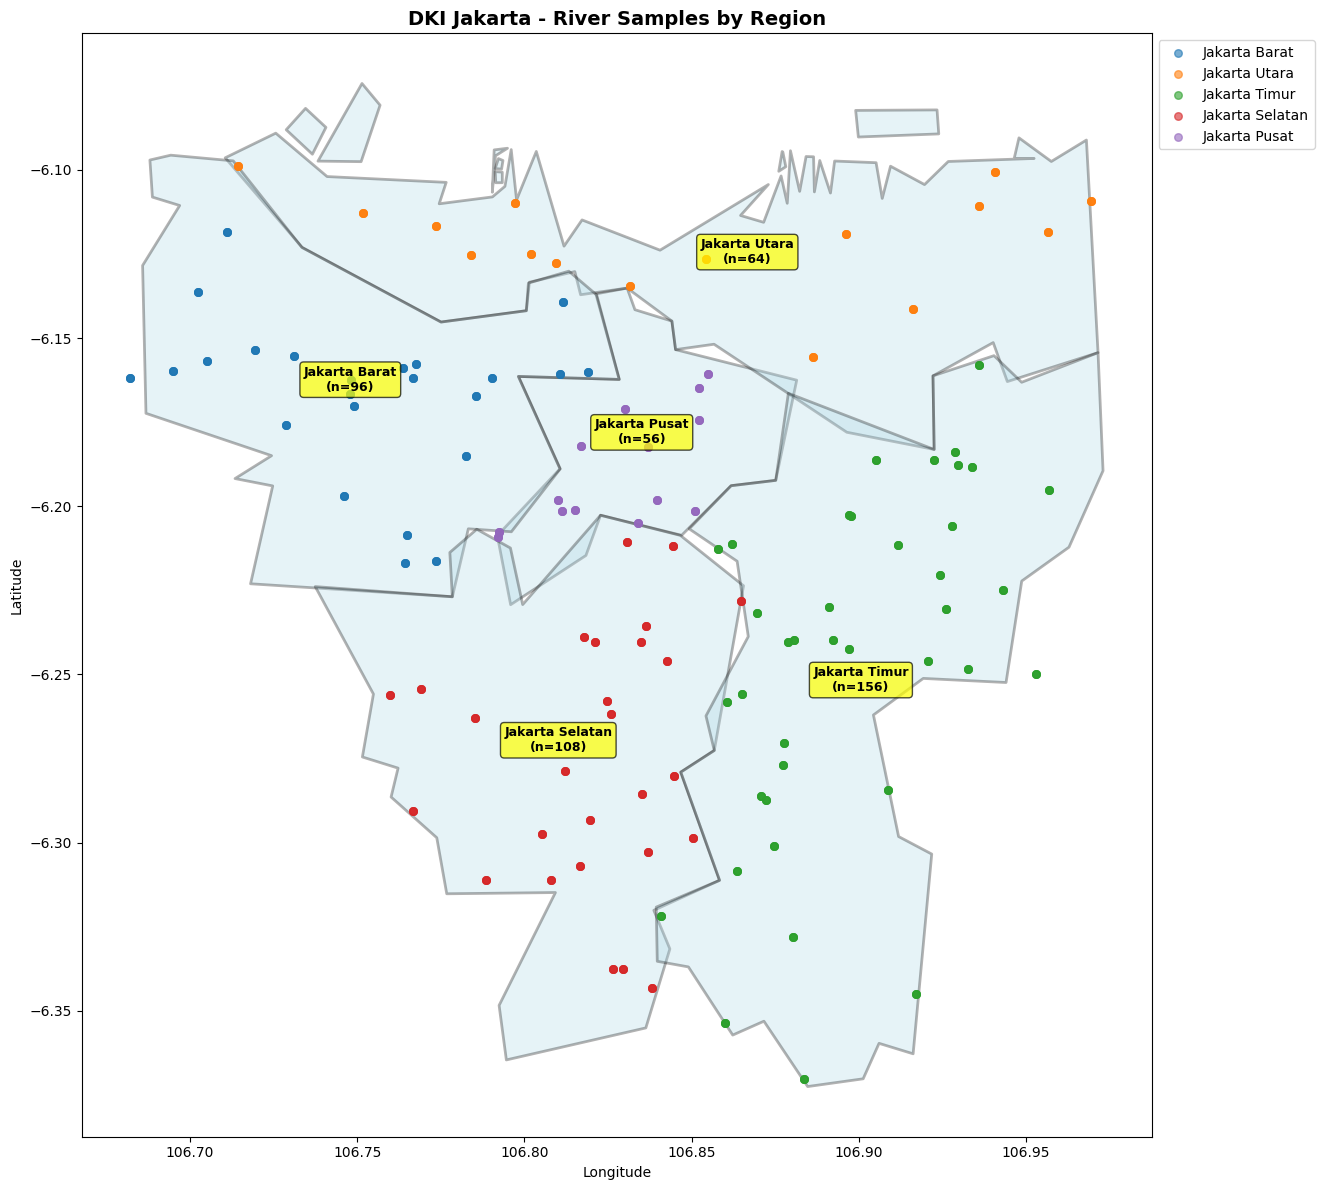

In [60]:
# Visualize regional assignments
fig, ax = plt.subplots(figsize=(14, 12))

# Plot boundaries
gdf_boundaries.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.3, linewidth=2, aspect=None)

# Plot samples colored by region
for kota in gdf_sungai_with_region['kota_kabupaten'].unique():
    samples = gdf_sungai_with_region[gdf_sungai_with_region['kota_kabupaten'] == kota]
    samples.plot(ax=ax, markersize=30, alpha=0.6, label=kota.replace('Kota Administrasi ', ''))

# Add labels to boundaries
for _, row in gdf_boundaries.iterrows():
    centroid = row.geometry.centroid
    short_name = row['nama'].replace('Kota Administrasi ', '')
    count = (gdf_sungai_with_region['kota_kabupaten'] == row['nama']).sum()
    ax.annotate(text=f"{short_name}\n(n={count})", xy=(centroid.x, centroid.y), 
                ha='center', fontsize=9, weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
ax.set_title('DKI Jakarta - River Samples by Region', fontsize=14, weight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

## a

In [61]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Encode 'kategori' to numeric values
# # Typical ISPU categories: BAIK < SEDANG < TIDAK SEHAT < SANGAT TIDAK SEHAT < BERBAHAYA
# kategori_mapping = {
#     'BAIK': 1,
#     'SEDANG': 2,
#     'TIDAK SEHAT': 3,
#     'SANGAT TIDAK SEHAT': 4,
#     'BERBAHAYA': 5
# }

# # Create a copy with encoded kategori
# df_encoded = ispu_river_df.copy()
# df_encoded['kategori_encoded'] = df_encoded['kategori'].map(kategori_mapping)

# # Select only numeric columns including the encoded kategori
# numeric_cols = df_encoded.select_dtypes(include=['number']).columns.tolist()

# # Calculate correlation with kategori_encoded
# correlations = df_encoded[numeric_cols].corr()['kategori_encoded'].sort_values(ascending=False)

# # Display top correlations (excluding kategori_encoded itself)
# print("=== Top Positive Correlations with Kategori ===")
# print(correlations[correlations.index != 'kategori_encoded'].head(15))
# print("\n=== Top Negative Correlations with Kategori ===")
# print(correlations[correlations.index != 'kategori_encoded'].tail(15))

# # Visualization 1: Bar plot of correlations with kategori
# fig, ax = plt.subplots(figsize=(12, 10))
# top_n = 20
# top_correlations = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(top_n)
# correlation_values = correlations[top_correlations.index].sort_values()

# colors = ['red' if x < 0 else 'green' for x in correlation_values]
# correlation_values.plot(kind='barh', color=colors, ax=ax)
# ax.set_xlabel('Correlation Coefficient', fontsize=12)
# ax.set_ylabel('Parameters', fontsize=12)
# ax.set_title(f'Top {top_n} Parameters Correlated with ISPU Kategori', fontsize=14, weight='bold')
# ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
# ax.grid(axis='x', alpha=0.3)
# plt.tight_layout()
# plt.show()

# # Visualization 2: Focused heatmap with kategori and top correlated features
# top_features = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(15).index.tolist()
# focused_features = ['kategori_encoded'] + top_features
# correlation_matrix_focused = df_encoded[focused_features].corr()

# plt.figure(figsize=(14, 12))
# sns.heatmap(correlation_matrix_focused, annot=True, fmt='.2f', cmap='coolwarm', 
#             center=0, square=True, linewidths=0.5, 
#             cbar_kws={"shrink": 0.8, "label": "Correlation"})
# plt.title('Correlation Matrix - ISPU and River Quality Parameters', 
#           fontsize=14, weight='bold')
# plt.tight_layout()
# plt.show()

# # Visualization 3: Scatter plots for top 6 correlated parameters
# top_6_features = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(6).index.tolist()

# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = axes.flatten()

# for idx, feature in enumerate(top_6_features):
#     ax = axes[idx]
#     df_plot = df_encoded.dropna(subset=[feature, 'kategori_encoded'])
#     ax.scatter(df_plot[feature], df_plot['kategori_encoded'], alpha=0.5)
#     ax.set_xlabel(feature, fontsize=10)
#     ax.set_ylabel('Kategori (encoded)', fontsize=10)
#     ax.set_title(f'Corr: {correlations[feature]:.3f}', fontsize=11, weight='bold')
#     ax.grid(alpha=0.3)

# plt.suptitle('Top 6 Parameters vs ISPU Kategori', fontsize=16, weight='bold')
# plt.tight_layout()
# plt.show()

# River Water Quality Data

In [62]:
def correct_num_format(df, cols):
    """
    Convert European number format (dot as thousands, comma as decimal) to standard format.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame to modify (modified in-place)
    cols : list
        List of column names to convert
    """
    for col in cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace('.', '', regex=False)      # Remove thousands separator
                .str.replace(',', '.', regex=False)      # Replace decimal separator
                .replace(['', 'nan', 'None'], pd.NA)     # Handle empty/null strings
            )
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

## sampling location

In [63]:
import camelot

# 'lattice' flavor is best for tables with visible grid lines (like yours)
sampling_locs = camelot.read_pdf("airsungai_20250702121933.pdf", pages="60-62", flavor='lattice')

In [64]:
sampling_locs_header = ["No","Kode","Sungai","Sub Jaringan","Alamat","DAS","Lintang (DD)","Bujur (DD)","Lintang (DMS)","Bujur (DMS)"]
header_correction = {
    'Lintang (DD)': 'lat',
    'Bujur (DD)': 'lng'
}

In [65]:
slocs = []
for sloc in sampling_locs:
    df_sloc = sloc.df.iloc[2:]
    df_sloc.columns = sampling_locs_header
    df_sloc = df_sloc[['Kode', 'Lintang (DD)', 'Bujur (DD)']].rename(columns = header_correction)
    df_sloc = correct_num_format(df_sloc, ['lat', 'lng'])
    slocs.append(df_sloc)
slocs = pd.concat(slocs, ignore_index=True)


In [66]:
locs = sampling_locs[0].df.iloc[2:].copy()
locs.columns = sampling_locs_header
locs = locs[['Kode', 'Lintang (DD)', 'Bujur (DD)']].rename(columns = header_correction)
locs = correct_num_format(locs, ['lat', 'lng'])
locs

,Kode,lat,lng
2,1,-6.346678,106.838256
3,2C,-6.316256,106.851606
4,2,-6.302536,106.854367
5,2B,-6.258125,106.860367
6,2A,-6.228269,106.864536
7,3,-6.212717,106.857703
8,3B,-6.204903,106.834008
9,4,-6.200900,106.815217
10,5,-6.198944,106.810822
11,6,-6.116667,106.773497


In [67]:
# Convert locs to GeoDataFrame
gdf_slocs = gpd.GeoDataFrame(
    slocs,
    geometry=gpd.points_from_xy(slocs.lng, slocs.lat),
    crs='EPSG:4326'
)

# Spatial join with boundaries to get kota_kabupaten
gdf_slocs_with_region = gpd.sjoin(
    gdf_slocs,
    gdf_boundaries[['nama', 'geometry']],
    how='left',
    predicate='within'
)

# Clean up and assign to nearest if not within any boundary
if 'index_right' in gdf_slocs_with_region.columns:
    gdf_slocs_with_region = gdf_slocs_with_region.drop(columns=['index_right'])

gdf_slocs_with_region = gdf_slocs_with_region.rename(columns={'nama': 'kota_kabupaten'})

# Assign unassigned locations to nearest boundary
gdf_slocs_with_region = assign_to_nearest_region(gdf_slocs_with_region, gdf_boundaries, nama_col='kota_kabupaten')

# Convert back to DataFrame and add stasiun column
slocs_with_stasiun = pd.DataFrame(gdf_slocs_with_region.drop(columns=['lat', 'lng', 'geometry']))
slocs_with_stasiun['kota_kabupaten'] = slocs_with_stasiun['kota_kabupaten'].str.replace('Kota Administrasi ', '')
# Map to stasiun codes
slocs_with_stasiun = add_stasiun_column(slocs_with_stasiun, stasiun_mapping).drop(columns=['kota_kabupaten'])

slocs_with_stasiun

Assigning 6 samples to nearest boundaries...


,Kode,stasiun
0,1,DKI3
1,2C,DKI4
2,2,DKI3
3,2B,DKI4
4,2A,DKI3
...,...,...
106,23,DKI3
107,23A,DKI3
108,49,DKI5
109,49A,DKI5


## pdf loading 

|Tahun|Periode|page|
|---|---|---|
|2015|1|66|
|2015|2|69|
|2015|3|72|
|2016|1|75|
|2016|2|78|
|2017|1|81|
|2017|2|84|
|2017|3|87|
|2018|1|90|
|2018|2|93|
|2018|3|96|
|2018|4|99|
|2019|1|102|
|2019|2|105|
|2019|3|108|
|2019|4|111|

In [68]:
data_separation = {
    2015: 3,
    2016: 2,
    2017: 3,
    2018: 4,
    2019: 4
}

In [69]:
import camelot

# 'lattice' flavor is best for tables with visible grid lines (like yours)
tables = camelot.read_pdf("airsungai_20250702121933.pdf", pages="66-113", flavor='lattice')

In [177]:
# Load 2020 data tables (page 115 contains the 2020 table split across 2 sub-tables)
table2020 = camelot.read_pdf("airsungai_20250702121933.pdf", pages="115", flavor='lattice')

In [70]:
numeric_cols = ["TDS", "TSS", "pH", "BOD", "COD", "Cd", "Cr6+", "Cu", "Pb", "Hg", "Zn", 
                "Minyak dan Lemak", "MBAS", "Bakteri Koli", "Bakteri Koli Tinja"]

In [71]:
headers = ["no", "Kode", "Sungai", "DAS", *numeric_cols]

In [97]:
river_params_dict = {
  "total_dissolved_solids": {
    "params1": "TDS",
    "params2": "TDS",
    "params3": "ZAT PADAT TERLARUT TDS"
  },
  "total_suspended_solids": {
    "params1": "TSS",
    "params2": "TSS",
    "params3": "ZAT PADAT TERSUSPENSI TSS"
  },
  "ph": {
    "params1": "pH",
    "params2": "pH",
    "params3": "PH"
  },
  "biological_oxygen_demand": {
    "params1": "BOD",
    "params2": "BOD",
    "params3": "BOD"
  },
  "chemical_oxygen_demand": {
    "params1": "COD",
    "params2": "COD",
    "params3": "COD DICHROMAT"
  },
  "cadmium": {
    "params1": "Cd",
    "params2": "Cd",
    "params3": "KADMIUM CD"
  },
  "chromium_vi": {
    "params1": "Cr6+",
    "params2": "Cr6",
    "params3": "CROM HEXAVALEN CR6"
  },
  "copper": {
    "params1": "Cu",
    "params2": "Cu",
    "params3": "TEMBAGA CU"
  },
  "lead": {
    "params1": "Pb",
    "params2": "Pb",
    "params3": "TIMAH HITAM PB"
  },
  "mercury": {
    "params1": "Hg",
    "params2": "Hg",
    "params3": "HG"
  },
  "zinc": {
    "params1": "Zn",
    "params2": "Zn",
    "params3": "SENG ZN"
  },
  "oil_and_grease": {
    "params1": "Minyak dan Lemak",
    "params2": "Minyak dan Lemak",
    "params3": "MINYAK DAN LEMAK"
  },
  "mbas_detergent": {
    "params1": "MBAS",
    "params2": "MBAS",
    "params3": "MBAS"
  },
  "total_coliform": {
    "params1": "Bakteri Koli",
    "params2": "Total Coliform",
    "params3": "TOTAL COLIFORM"
  },
  "fecal_coliform": {
    "params1": "Bakteri Koli Tinja",
    "params2": "Fecal Coliform",
    "params3": "FECAL COLIFORM"
  }
}

param_rename_map = {v['params1']: k for k, v in river_params_dict.items()}

In [73]:
data_separation.values()

dict_values([3, 2, 3, 4, 4])

In [74]:
sum_n_tables = sum(data_separation.values())
processed_tables = 0
tabs = []

# Process each year and its periods
for year, num_periods in data_separation.items():
    print(f"\n{'='*50}")
    print(f"Processing Year: {year} ({num_periods} periods)")
    print(f"{'='*50}")
    
    for period in range(1, num_periods + 1):
        print(f"\n--- Period {period} ---")
        # Each period has 3 pages (3 tables)
        table_indices = [processed_tables, processed_tables + 1, processed_tables + 2]
        print(f"Processing tables at indices: {table_indices}")
        
        period_dfs = []
        for idx in table_indices:
            table = tables[idx].df.iloc[5:].copy()
            table.columns = headers
            table = correct_num_format(table.drop(columns=["no"]), numeric_cols)
            table = table.merge(slocs_with_stasiun[['Kode', 'stasiun']], on='Kode', how='left')
            table = table.rename(columns=param_rename_map)
            period_dfs.append(table)
        
        # Combine all 3 tables for the period
        period_combined = pd.concat(period_dfs, ignore_index=True)
        
        _agg_list = ['mean']
        # Aggregate by stasiun
        period_agg = period_combined.groupby('stasiun').agg({
            col: _agg_list for col in param_rename_map.values()
        }).reset_index()
        
        if len(_agg_list) > 1:
            period_agg.columns = ['stasiun'] + [f'{col} {stat}' for col in param_rename_map.values() for stat in _agg_list]
        else:
            period_agg.columns = ['stasiun'] + [f'{col}' for col in param_rename_map.values()]
        period_agg['tahun'] = year
        period_agg['periode'] = period
        
        tabs.append(period_agg)
        print(f"✓ Period {period} processed")
        
        # Move to next period (3 tables forward)
        processed_tables += 3

print(f"\n{'='*50}")
print(f"Total periods processed: {len(tabs)}")
print(f"{'='*50}")

# Combine all periods
river_quality_all = pd.concat(tabs, ignore_index=True)
river_quality_all


Processing Year: 2015 (3 periods)

--- Period 1 ---
Processing tables at indices: [0, 1, 2]
✓ Period 1 processed

--- Period 2 ---
Processing tables at indices: [3, 4, 5]
✓ Period 2 processed

--- Period 3 ---
Processing tables at indices: [6, 7, 8]
✓ Period 3 processed

Processing Year: 2016 (2 periods)

--- Period 1 ---
Processing tables at indices: [9, 10, 11]
✓ Period 1 processed

--- Period 2 ---
Processing tables at indices: [12, 13, 14]
✓ Period 2 processed

Processing Year: 2017 (3 periods)

--- Period 1 ---
Processing tables at indices: [15, 16, 17]
✓ Period 1 processed

--- Period 2 ---
Processing tables at indices: [18, 19, 20]
✓ Period 2 processed

--- Period 3 ---
Processing tables at indices: [21, 22, 23]
✓ Period 3 processed

Processing Year: 2018 (4 periods)

--- Period 1 ---
Processing tables at indices: [24, 25, 26]
✓ Period 1 processed

--- Period 2 ---
Processing tables at indices: [27, 28, 29]
✓ Period 2 processed

--- Period 3 ---
Processing tables at indices: [3

,stasiun,total_dissolved_solids,total_suspended_solids,ph,biological_oxygen_demand,chemical_oxygen_demand,cadmium,chromium_vi,copper,lead,mercury,zinc,oil_and_grease,mbas_detergent,total_coliform,fecal_coliform,tahun,periode
0,DKI1,305.600000,123.800000,7.320000,19.780000,96.640000,0.009,0.003,0.009000,0.009500,0.000340,0.010000,820.000000,862.000000,7.440000e+06,2.736000e+06,2015,1
1,DKI2,1745.000000,77.923077,7.384615,21.369231,126.969231,0.009,0.003,0.002462,0.011250,0.000731,0.016923,410.000000,653.076923,4.141131e+06,1.281008e+06,2015,1
2,DKI3,266.650000,79.750000,7.200000,22.380000,143.000000,0.009,0.003,0.004450,0.019111,0.000345,0.018000,675.000000,739.500000,5.552500e+07,2.655895e+07,2015,1
3,DKI4,365.888889,99.185185,7.362963,18.825926,102.214815,0.009,0.003,0.015370,0.015741,0.000385,0.016296,326.666667,922.222222,2.462545e+07,5.938711e+06,2015,1
4,DKI5,567.842105,69.315789,7.410526,25.673684,141.168421,0.009,0.003,0.004000,0.017857,0.000816,0.064211,480.526316,725.263158,4.417526e+06,1.761684e+06,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,DKI1,351.750000,34.250000,6.733333,29.325000,82.566667,0.010,0.003,0.019000,NaN,0.000300,0.012500,497.308333,861.083333,3.494950e+08,2.174900e+08,2019,4
76,DKI2,1309.142857,40.642857,7.321429,25.142857,75.428571,0.010,0.003,0.019000,NaN,0.000300,0.027143,623.428571,951.500000,7.825533e+07,4.403949e+07,2019,4
77,DKI3,278.360000,50.000000,7.236000,34.568000,90.636000,0.010,0.003,0.019000,NaN,0.000300,0.010000,661.160000,765.960000,2.765987e+09,1.898678e+09,2019,4
78,DKI4,450.083333,54.111111,7.391667,41.202778,111.552778,0.010,0.003,0.019000,NaN,0.000300,0.012500,690.669444,1259.555556,6.415635e+08,4.027484e+08,2019,4


### testing

In [75]:
testdf = tables[0].df.iloc[5:].copy()
testdf.columns = headers
testdf = testdf.drop(columns = ["no"])

testdf = correct_num_format(testdf, numeric_cols)

# Merge with slocs_with_stasiun to add 'stasiun' column
testdf = testdf.merge(slocs_with_stasiun[['Kode', 'stasiun']], on='Kode', how='left')

# Check for unmatched codes
unmatched = testdf[testdf['stasiun'].isna()]['Kode'].unique()
if len(unmatched) > 0:
    print(f"Warning: {len(unmatched)} codes could not be matched:")
    print(unmatched)

testdf = testdf.reset_index(drop=True)
testdf

,Kode,Sungai,DAS,TDS,TSS,pH,BOD,COD,Cd,Cr6+,Cu,Pb,Hg,Zn,Minyak dan Lemak,MBAS,Bakteri Koli,Bakteri Koli Tinja,stasiun
0,1,Ciliwung,Ciliwung,132.0,12.0,7.3,4.6,15.5,0.009,0.003,0.001,0.004,0.0003,0.02,0.0,280.0,24000.0,3000.0,DKI3
1,2C,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI4
2,2,Ciliwung,Ciliwung,155.0,14.0,7.4,5.4,15.5,0.009,0.003,0.003,0.004,0.0010,0.02,250.0,170.0,28000.0,5000.0,DKI3
3,2B,Ciliwung,Ciliwung,210.0,84.0,7.2,11.7,31.1,0.009,0.003,0.004,0.010,0.0010,0.01,750.0,560.0,1400000.0,400000.0,DKI4
4,2A,Ciliwung,Ciliwung,175.0,36.0,7.3,11.2,31.1,0.009,0.003,0.001,0.006,0.0004,0.02,140.0,480.0,166000.0,46000.0,DKI3
5,3,Ciliwung,Ciliwung,196.0,64.0,7.2,10.3,31.1,0.009,0.003,0.002,0.005,0.0010,0.02,340.0,590.0,860000.0,290000.0,DKI4
6,3B,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI1
7,4,Ciliwung,Ciliwung,259.0,56.0,7.2,15.1,77.7,0.009,0.003,0.040,0.009,0.0003,0.00,250.0,1250.0,6700000.0,3000000.0,DKI1
8,5,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI1
9,6,Ciliwung,Angke-Pesanggrahan,776.0,73.0,6.7,16.1,78.4,0.009,0.003,0.005,0.010,0.0003,0.00,0.0,790.0,4000000.0,1100000.0,DKI2


In [76]:
testdf.columns

Index(['Kode', 'Sungai', 'DAS', 'TDS', 'TSS', 'pH', 'BOD', 'COD', 'Cd', 'Cr6+',
       'Cu', 'Pb', 'Hg', 'Zn', 'Minyak dan Lemak', 'MBAS', 'Bakteri Koli',
       'Bakteri Koli Tinja', 'stasiun'],
      dtype='str')

In [77]:
river_params_new = ['TDS', 'TSS', 'pH', 'BOD', 'COD', 'Cd', 'Cr6+',
       'Cu', 'Pb', 'Hg', 'Zn', 'Minyak dan Lemak', 'MBAS', 'Bakteri Koli',
       'Bakteri Koli Tinja']

In [78]:
# Create a rename mapping from river_params_dict
rename_mapping = {v['params1']: k for k, v in river_params_dict.items()}

# Rename columns in testdf
testdf = testdf.rename(columns=rename_mapping)
testdf

,Kode,Sungai,DAS,total_dissolved_solids,total_suspended_solids,ph,biological_oxygen_demand,chemical_oxygen_demand,cadmium,chromium_vi,copper,lead,mercury,zinc,oil_and_grease,mbas_detergent,total_coliform,fecal_coliform,stasiun
0,1,Ciliwung,Ciliwung,132.0,12.0,7.3,4.6,15.5,0.009,0.003,0.001,0.004,0.0003,0.02,0.0,280.0,24000.0,3000.0,DKI3
1,2C,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI4
2,2,Ciliwung,Ciliwung,155.0,14.0,7.4,5.4,15.5,0.009,0.003,0.003,0.004,0.0010,0.02,250.0,170.0,28000.0,5000.0,DKI3
3,2B,Ciliwung,Ciliwung,210.0,84.0,7.2,11.7,31.1,0.009,0.003,0.004,0.010,0.0010,0.01,750.0,560.0,1400000.0,400000.0,DKI4
4,2A,Ciliwung,Ciliwung,175.0,36.0,7.3,11.2,31.1,0.009,0.003,0.001,0.006,0.0004,0.02,140.0,480.0,166000.0,46000.0,DKI3
5,3,Ciliwung,Ciliwung,196.0,64.0,7.2,10.3,31.1,0.009,0.003,0.002,0.005,0.0010,0.02,340.0,590.0,860000.0,290000.0,DKI4
6,3B,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI1
7,4,Ciliwung,Ciliwung,259.0,56.0,7.2,15.1,77.7,0.009,0.003,0.040,0.009,0.0003,0.00,250.0,1250.0,6700000.0,3000000.0,DKI1
8,5,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI1
9,6,Ciliwung,Angke-Pesanggrahan,776.0,73.0,6.7,16.1,78.4,0.009,0.003,0.005,0.010,0.0003,0.00,0.0,790.0,4000000.0,1100000.0,DKI2


In [79]:
testdf_agg = testdf.groupby('stasiun').agg({
    col: ['mean', 'median'] for col in rename_mapping.values()
}).reset_index()

testdf_agg.columns = ['stasiun'] + [f'{col} {stat}' for col in rename_mapping.values() for stat in ['mean', 'median']]

In [80]:
testdf_agg

,stasiun,total_dissolved_solids mean,total_dissolved_solids median,total_suspended_solids mean,total_suspended_solids median,ph mean,ph median,biological_oxygen_demand mean,biological_oxygen_demand median,chemical_oxygen_demand mean,chemical_oxygen_demand median,cadmium mean,cadmium median,chromium_vi mean,chromium_vi median,copper mean,copper median,lead mean,lead median,mercury mean,mercury median,zinc mean,zinc median,oil_and_grease mean,oil_and_grease median,mbas_detergent mean,mbas_detergent median,total_coliform mean,total_coliform median,fecal_coliform mean,fecal_coliform median
0,DKI1,244.500000,244.5,46.500000,46.5,7.250000,7.25,9.750000,9.75,54.550000,54.55,0.009,0.009,0.003,0.003,0.021000,0.021,0.009500,0.0095,0.000400,0.00040,0.000000,0.00,125.000000,125.0,1045.000000,1045.0,6.300000e+06,6300000.0,2.350000e+06,2350000.0
1,DKI2,689.000000,639.5,84.000000,72.0,7.200000,7.25,15.125000,16.10,82.325000,78.40,0.009,0.009,0.003,0.003,0.004750,0.004,0.010000,0.0100,0.000300,0.00030,0.010000,0.01,62.500000,0.0,747.500000,635.0,1.887500e+06,1640000.0,5.525000e+05,530000.0
2,DKI3,208.250000,165.0,31.000000,25.0,7.325000,7.30,13.925000,8.30,62.575000,23.30,0.009,0.009,0.003,0.003,0.003750,0.002,0.006000,0.0050,0.000500,0.00035,0.022500,0.02,1050.000000,195.0,397.500000,380.0,2.205450e+07,97000.0,8.263500e+06,25500.0
3,DKI4,383.571429,373.0,87.571429,84.0,7.328571,7.20,20.071429,15.30,124.457143,125.50,0.009,0.009,0.003,0.003,0.003429,0.003,0.009286,0.0100,0.000529,0.00030,0.008571,0.01,440.000000,420.0,861.428571,720.0,6.013714e+07,7400000.0,1.118429e+07,2400000.0
4,DKI5,334.857143,355.0,59.142857,42.0,7.371429,7.40,20.100000,12.10,95.657143,77.70,0.009,0.009,0.003,0.003,0.003714,0.001,0.010000,0.0100,0.000400,0.00030,0.008571,0.01,641.428571,100.0,750.000000,760.0,4.522857e+06,1190000.0,1.894286e+06,330000.0


## 2020 pdf loading

In [165]:
def handle_range_values(value):
    """
    Handle range values like '<0.002', '>10', '≤5', etc.
    Extracts the numeric value and ignores comparison operators.
    
    Parameters:
    -----------
    value : str
        String that may contain comparison operators and numbers
    
    Returns:
    --------
    str
        Cleaned numeric string
    """
    import re
    if pd.isna(value) or value == '':
        return value
    
    # Convert to string
    value_str = str(value)
    
    # Remove common comparison operators and whitespace
    # Handles: <, >, ≤, ≥, <=, >=, <space>
    value_str = re.sub(r'^[<>≤≥\s]+|[<>=≤≥\s]+$', '', value_str)
    
    return value_str


def correct_european_number_format(df, cols):
    """
    Convert European number format (dot as thousands, comma as decimal) to standard format.
    Also handles range values like '<0.002' or '>10'.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame to modify (modified in-place)
    cols : list
        List of column names to convert
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with converted columns
    """
    for col in cols:
        if col in df.columns:
            # First handle range values (remove <, >, ≤, ≥, etc.)
            df[col] = df[col].apply(handle_range_values)
            
            # Then handle European number format
            df[col] = (
                df[col]
                .astype(str)
                .str.replace('.', '', regex=False)      # Remove thousands separator
                .str.replace(',', '.', regex=False)      # Replace decimal separator
                .replace(['', 'nan', 'None'], pd.NA)     # Handle empty/null strings
            )
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

## csv loading

In [81]:
sungai_df = pd.read_csv('sungai2022.csv', sep = ";")
sungai_df = correct_num_format(sungai_df, ['lintang', 'bujur', 'hasil_pengukuran'])
sungai_df = sungai_df[['tahun', 'bulan_sampling', 'lintang', 'bujur','jenis_parameter', 'parameter', 'hasil_pengukuran']]

In [82]:
sungai_df.columns

Index(['tahun', 'bulan_sampling', 'lintang', 'bujur', 'jenis_parameter',
       'parameter', 'hasil_pengukuran'],
      dtype='str')

In [83]:
sungai_df['jenis_parameter'].value_counts()

jenis_parameter
KIMIA        11282
FISIKA        1318
BIOLOGI        960
NILAI IP       475
STATUS IP      475
Name: count, dtype: int64

In [84]:
sungai_df

,tahun,bulan_sampling,lintang,bujur,jenis_parameter,parameter,hasil_pengukuran
0,2022,202203,-6.292639,106.853500,KIMIA,F,0.019000
1,2022,202203,-6.292639,106.853500,KIMIA,H2S,0.011000
2,2022,202203,-6.292639,106.853500,KIMIA,KLORIN BEBAS,0.390000
3,2022,202203,-6.292639,106.853500,KIMIA,HG,0.000049
4,2022,202203,-6.292639,106.853500,KIMIA,KADMIUM CD,0.005900
...,...,...,...,...,...,...,...
14507,2022,202210,-6.290602,106.766668,KIMIA,SULFAT,10.400000
14508,2022,202210,-6.290602,106.766668,KIMIA,KLORIDA,32.150000
14509,2022,202210,-6.290602,106.766668,KIMIA,AMONIAK,0.250000
14510,2022,202210,-6.290602,106.766668,KIMIA,TOTAL N,NaN


In [85]:
params_sungai = ['KIMIA', 'FISIKA', 'BIOLOGI'] 

index_columns = ['tahun', 'bulan_sampling', 'lintang', 'bujur']
parameter_columns = 'parameter'
value_columns = 'hasil_pengukuran'

In [86]:
sungai_df = sungai_df.groupby(['tahun', 'bulan_sampling', 'lintang', 'bujur', 'jenis_parameter', 'parameter'], as_index=False)['hasil_pengukuran'].mean()

sungai_dfs = []
for param in params_sungai:
    _sungai_df = sungai_df[sungai_df['jenis_parameter'] == param]
    _sungai_df = _sungai_df.pivot(index=index_columns, columns=parameter_columns, values=value_columns)
    _sungai_df = _sungai_df.reset_index()
    print(len(_sungai_df))
    sungai_dfs.append(_sungai_df)

478
478
478


In [89]:
sungai_dfs[0].columns

Index(['tahun', 'bulan_sampling', 'lintang', 'bujur', 'AMONIAK', 'BOD',
       'COD DICHROMAT', 'CROM HEXAVALEN CR6', 'DO', 'F', 'FENOL', 'H2S', 'HG',
       'KADMIUM CD', 'KLORIDA', 'KLORIN BEBAS', 'MBAS', 'MINYAK DAN LEMAK',
       'NI', 'NITRAT NO3', 'NITRIT', 'PH', 'SENG ZN', 'SIANIDA', 'SULFAT',
       'TEMBAGA CU', 'TIMAH HITAM PB', 'TOTAL N', 'TOTAL P'],
      dtype='str', name='parameter')

In [87]:
sungai_df['hasil_pengukuran'][(sungai_df['jenis_parameter'] == 'KIMIA') & (sungai_df['parameter'] == "TOTAL N")].count()

np.int64(0)

In [90]:
common_cols = ['tahun', 'bulan_sampling', 'lintang', 'bujur']

sungai_df = reduce(lambda left, right: pd.merge(left, right, on=common_cols, how='inner'), sungai_dfs)
sungai_df.columns.name = None

In [98]:
param_rename_map = {v['params3']: k for k, v in river_params_dict.items()}

In [105]:
river_params_dict.keys()

dict_keys(['total_dissolved_solids', 'total_suspended_solids', 'ph', 'biological_oxygen_demand', 'chemical_oxygen_demand', 'cadmium', 'chromium_vi', 'copper', 'lead', 'mercury', 'zinc', 'oil_and_grease', 'mbas_detergent', 'total_coliform', 'fecal_coliform'])

In [106]:
sungai_df = sungai_df.rename(columns=param_rename_map)
sungai_df = sungai_df[['tahun', 'bulan_sampling', 'lintang', 'bujur', *river_params_dict.keys()]]

In [96]:
sungai_df.columns

Index(['tahun', 'bulan_sampling', 'lintang', 'bujur', 'AMONIAK', 'BOD',
       'COD DICHROMAT', 'CROM HEXAVALEN CR6', 'DO', 'F', 'FENOL', 'H2S', 'HG',
       'KADMIUM CD', 'KLORIDA', 'KLORIN BEBAS', 'MBAS', 'MINYAK DAN LEMAK',
       'NI', 'NITRAT NO3', 'NITRIT', 'PH', 'SENG ZN', 'SIANIDA', 'SULFAT',
       'TEMBAGA CU', 'TIMAH HITAM PB', 'TOTAL N', 'TOTAL P', 'WARNA',
       'ZAT PADAT TERLARUT TDS', 'ZAT PADAT TERSUSPENSI TSS', 'FECAL COLIFORM',
       'TOTAL COLIFORM'],
      dtype='str')

In [107]:
sungai_df.columns

Index(['tahun', 'bulan_sampling', 'lintang', 'bujur', 'total_dissolved_solids',
       'total_suspended_solids', 'ph', 'biological_oxygen_demand',
       'chemical_oxygen_demand', 'cadmium', 'chromium_vi', 'copper', 'lead',
       'mercury', 'zinc', 'oil_and_grease', 'mbas_detergent', 'total_coliform',
       'fecal_coliform'],
      dtype='str')

In [109]:
sungai_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tahun                     478 non-null    int64  
 1   bulan_sampling            478 non-null    int64  
 2   lintang                   478 non-null    float64
 3   bujur                     478 non-null    float64
 4   total_dissolved_solids    477 non-null    float64
 5   total_suspended_solids    477 non-null    float64
 6   ph                        478 non-null    float64
 7   biological_oxygen_demand  478 non-null    float64
 8   chemical_oxygen_demand    478 non-null    float64
 9   cadmium                   478 non-null    float64
 10  chromium_vi               478 non-null    float64
 11  copper                    478 non-null    float64
 12  lead                      478 non-null    float64
 13  mercury                   478 non-null    float64
 14  zinc                 

In [110]:
sungai_df.head()

,tahun,bulan_sampling,lintang,bujur,total_dissolved_solids,total_suspended_solids,ph,biological_oxygen_demand,chemical_oxygen_demand,cadmium,chromium_vi,copper,lead,mercury,zinc,oil_and_grease,mbas_detergent,total_coliform,fecal_coliform
0,2022,202203,-6.370171,106.883453,167.0,5.0,7.33,11.490,55.0,0.0059,0.0029,0.030,0.0190,0.000049,0.0300,0.539,0.230,5000000.0,1700000.0
1,2022,202203,-6.353515,106.859912,93.5,904.0,7.70,26.340,246.0,0.0059,0.0029,0.010,0.0190,0.000049,0.0550,0.620,0.029,500000.0,300000.0
2,2022,202203,-6.346698,106.838267,95.7,211.5,7.72,15.235,64.5,0.0059,0.0029,0.009,0.0395,0.000049,0.0140,0.539,0.029,50000.0,21500.0
3,2022,202203,-6.345091,106.917216,101.2,34.0,7.46,4.950,23.0,0.0059,0.0029,0.010,0.0300,0.000049,0.0069,0.539,0.080,500000.0,170000.0
4,2022,202203,-6.337577,106.829340,99.3,25.0,7.64,15.980,62.0,0.0059,0.0029,0.009,0.0190,0.000049,0.0069,0.539,0.029,5000000.0,2200000.0


In [116]:
sungai_df['bulan_sampling'][0].astype(str)[4:]

'03'

In [120]:
sungai_df['bulan_sampling'][0].astype(str)[:4] + '-' + sungai_df['bulan_sampling'][0].astype(str)[4:] + "-15"

'2022-03-15'

In [121]:
sungai_df['tanggal'] = sungai_df['bulan_sampling'].astype(str).str[:4] + '-' + sungai_df['bulan_sampling'].astype(str).str[4:] + "-15"

sungai_df['tanggal'] = pd.to_datetime(
    sungai_df['tanggal'], 
    format='mixed',
    dayfirst=False,
    errors='raise'
)

In [123]:
sungai_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   tahun                     478 non-null    int64         
 1   bulan_sampling            478 non-null    int64         
 2   lintang                   478 non-null    float64       
 3   bujur                     478 non-null    float64       
 4   total_dissolved_solids    477 non-null    float64       
 5   total_suspended_solids    477 non-null    float64       
 6   ph                        478 non-null    float64       
 7   biological_oxygen_demand  478 non-null    float64       
 8   chemical_oxygen_demand    478 non-null    float64       
 9   cadmium                   478 non-null    float64       
 10  chromium_vi               478 non-null    float64       
 11  copper                    478 non-null    float64       
 12  lead                      478 non

In [124]:
# Convert sungai_df to GeoDataFrame using lintang and bujur
gdf_sungai_csv = gpd.GeoDataFrame(
    sungai_df,
    geometry=gpd.points_from_xy(sungai_df.bujur, sungai_df.lintang),
    crs='EPSG:4326'
)

# Spatial join with boundaries to get kota_kabupaten
gdf_sungai_csv_with_region = gpd.sjoin(
    gdf_sungai_csv,
    gdf_boundaries[['nama', 'geometry']],
    how='left',
    predicate='within'
)

# Clean up
if 'index_right' in gdf_sungai_csv_with_region.columns:
    gdf_sungai_csv_with_region = gdf_sungai_csv_with_region.drop(columns=['index_right'])

gdf_sungai_csv_with_region = gdf_sungai_csv_with_region.rename(columns={'nama': 'kota_kabupaten'})

# Assign unassigned locations to nearest boundary
gdf_sungai_csv_with_region = assign_to_nearest_region(gdf_sungai_csv_with_region, gdf_boundaries, nama_col='kota_kabupaten')

# Convert back to DataFrame
sungai_df_with_stasiun = pd.DataFrame(gdf_sungai_csv_with_region.drop(columns=['geometry']))
sungai_df_with_stasiun['kota_kabupaten'] = sungai_df_with_stasiun['kota_kabupaten'].str.replace('Kota Administrasi ', '')

# Map to stasiun codes
sungai_df_with_stasiun = add_stasiun_column(sungai_df_with_stasiun, stasiun_mapping)

print(f"\n✓ All {len(sungai_df_with_stasiun)} samples assigned to regions")
print("\nDistribution by stasiun:")
print(sungai_df_with_stasiun['stasiun'].value_counts().sort_index().to_string())

sungai_df_with_stasiun.head()

Assigning 24 samples to nearest boundaries...

✓ All 478 samples assigned to regions

Distribution by stasiun:
stasiun
DKI1     56
DKI2     64
DKI3    104
DKI4    158
DKI5     96


,tahun,bulan_sampling,lintang,bujur,total_dissolved_solids,total_suspended_solids,ph,biological_oxygen_demand,chemical_oxygen_demand,cadmium,chromium_vi,copper,lead,mercury,zinc,oil_and_grease,mbas_detergent,total_coliform,fecal_coliform,tanggal,kota_kabupaten,stasiun
0,2022,202203,-6.370171,106.883453,167.0,5.0,7.33,11.490,55.0,0.0059,0.0029,0.030,0.0190,0.000049,0.0300,0.539,0.230,5000000.0,1700000.0,2022-03-15,Jakarta Timur,DKI4
1,2022,202203,-6.353515,106.859912,93.5,904.0,7.70,26.340,246.0,0.0059,0.0029,0.010,0.0190,0.000049,0.0550,0.620,0.029,500000.0,300000.0,2022-03-15,Jakarta Timur,DKI4
2,2022,202203,-6.346698,106.838267,95.7,211.5,7.72,15.235,64.5,0.0059,0.0029,0.009,0.0395,0.000049,0.0140,0.539,0.029,50000.0,21500.0,2022-03-15,Jakarta Selatan,DKI3
3,2022,202203,-6.345091,106.917216,101.2,34.0,7.46,4.950,23.0,0.0059,0.0029,0.010,0.0300,0.000049,0.0069,0.539,0.080,500000.0,170000.0,2022-03-15,Jakarta Timur,DKI4
4,2022,202203,-6.337577,106.829340,99.3,25.0,7.64,15.980,62.0,0.0059,0.0029,0.009,0.0190,0.000049,0.0069,0.539,0.029,5000000.0,2200000.0,2022-03-15,Jakarta Selatan,DKI3


In [125]:
# Create skeleton dataframe with all date-station combinations
# Get unique years from sungai_df_with_stasiun
years = sungai_df_with_stasiun['tahun'].unique()
print(f"Years in data: {sorted(years)}")

# Create all date-station combinations
skeleton_data = []

for year in years:
    # Create date range for the full year
    date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
    
    # Create combinations with all stations
    for date in date_range:
        for stasiun_code in stasiun_mapping.keys():
            skeleton_data.append({
                'tanggal': date,
                'stasiun': stasiun_code
            })

# Create skeleton dataframe
skeleton_df = pd.DataFrame(skeleton_data)
skeleton_df = skeleton_df.sort_values(['tanggal', 'stasiun']).reset_index(drop=True)

print(f"\nSkeleton dataframe created:")
print(f"  Total rows: {len(skeleton_df):,}")
print(f"  Date range: {skeleton_df['tanggal'].min()} to {skeleton_df['tanggal'].max()}")
print(f"  Stations: {sorted(skeleton_df['stasiun'].unique())}")
print(f"  Rows per station: {len(skeleton_df) // len(stasiun_mapping)}")

skeleton_df.head(10)

Years in data: [np.int64(2022)]

Skeleton dataframe created:
  Total rows: 1,825
  Date range: 2022-01-01 00:00:00 to 2022-12-31 00:00:00
  Stations: ['DKI1', 'DKI2', 'DKI3', 'DKI4', 'DKI5']
  Rows per station: 365


,tanggal,stasiun
0,2022-01-01,DKI1
1,2022-01-01,DKI2
2,2022-01-01,DKI3
3,2022-01-01,DKI4
4,2022-01-01,DKI5
5,2022-01-02,DKI1
6,2022-01-02,DKI2
7,2022-01-02,DKI3
8,2022-01-02,DKI4
9,2022-01-02,DKI5


In [126]:
# Merge skeleton with actual data
river_quality_columns = [col for col in sungai_df_with_stasiun.columns if col not in ['tanggal', 'stasiun']]

sungai_expanded = skeleton_df.merge(
    sungai_df_with_stasiun[['tanggal', 'stasiun'] + river_quality_columns],
    on=['tanggal', 'stasiun'],
    how='left'
)

# Apply backward and forward filling for each station
sungai_expanded[river_quality_columns] = (
    sungai_expanded.groupby('stasiun')[river_quality_columns]
    .transform(lambda x: x.bfill().ffill())
)

print(f"\nExpanded dataframe:")
print(f"  Total rows: {len(sungai_expanded):,}")
print(f"  Date range: {sungai_expanded['tanggal'].min()} to {sungai_expanded['tanggal'].max()}")
print(f"\nMissing values after filling:")
print(sungai_expanded[river_quality_columns].isnull().sum())

sungai_expanded.head(20)


Expanded dataframe:
  Total rows: 2,283
  Date range: 2022-01-01 00:00:00 to 2022-12-31 00:00:00

Missing values after filling:
tahun                       0
bulan_sampling              0
lintang                     0
bujur                       0
total_dissolved_solids      0
total_suspended_solids      0
ph                          0
biological_oxygen_demand    0
chemical_oxygen_demand      0
cadmium                     0
chromium_vi                 0
copper                      0
lead                        0
mercury                     0
zinc                        0
oil_and_grease              0
mbas_detergent              0
total_coliform              0
fecal_coliform              0
kota_kabupaten              0
dtype: int64


,tanggal,stasiun,tahun,bulan_sampling,lintang,bujur,total_dissolved_solids,total_suspended_solids,ph,biological_oxygen_demand,chemical_oxygen_demand,cadmium,chromium_vi,copper,lead,mercury,zinc,oil_and_grease,mbas_detergent,total_coliform,fecal_coliform,kota_kabupaten
0,2022-01-01,DKI1,2022.0,202203.0,-6.209111,106.791944,276.0,28.0,7.67,10.240,72.0,0.0059,0.0029,0.009,0.0190,0.000049,0.0100,0.539,0.480,28000000.0,9000000.0,Jakarta Pusat
1,2022-01-01,DKI2,2022.0,202203.0,-6.155556,106.886139,363.0,26.0,7.56,16.040,37.0,0.0059,0.0029,0.009,0.0190,0.000049,0.0069,1.250,0.690,35000000.0,11000000.0,Jakarta Utara
2,2022-01-01,DKI3,2022.0,202203.0,-6.346698,106.838267,95.7,211.5,7.72,15.235,64.5,0.0059,0.0029,0.009,0.0395,0.000049,0.0140,0.539,0.029,50000.0,21500.0,Jakarta Selatan
3,2022-01-01,DKI4,2022.0,202203.0,-6.370171,106.883453,167.0,5.0,7.33,11.490,55.0,0.0059,0.0029,0.030,0.0190,0.000049,0.0300,0.539,0.230,5000000.0,1700000.0,Jakarta Timur
4,2022-01-01,DKI5,2022.0,202203.0,-6.217084,106.764274,129.9,4.0,7.41,21.000,128.0,0.0059,0.0029,0.009,0.0190,0.000049,0.0069,0.539,0.070,2400000.0,70000.0,Jakarta Barat
5,2022-01-02,DKI1,2022.0,202203.0,-6.209111,106.791944,276.0,28.0,7.67,10.240,72.0,0.0059,0.0029,0.009,0.0190,0.000049,0.0100,0.539,0.480,28000000.0,9000000.0,Jakarta Pusat
6,2022-01-02,DKI2,2022.0,202203.0,-6.155556,106.886139,363.0,26.0,7.56,16.040,37.0,0.0059,0.0029,0.009,0.0190,0.000049,0.0069,1.250,0.690,35000000.0,11000000.0,Jakarta Utara
7,2022-01-02,DKI3,2022.0,202203.0,-6.346698,106.838267,95.7,211.5,7.72,15.235,64.5,0.0059,0.0029,0.009,0.0395,0.000049,0.0140,0.539,0.029,50000.0,21500.0,Jakarta Selatan
8,2022-01-02,DKI4,2022.0,202203.0,-6.370171,106.883453,167.0,5.0,7.33,11.490,55.0,0.0059,0.0029,0.030,0.0190,0.000049,0.0300,0.539,0.230,5000000.0,1700000.0,Jakarta Timur
9,2022-01-02,DKI5,2022.0,202203.0,-6.217084,106.764274,129.9,4.0,7.41,21.000,128.0,0.0059,0.0029,0.009,0.0190,0.000049,0.0069,0.539,0.070,2400000.0,70000.0,Jakarta Barat


# river data cleanup

## Helper Functions

In [ ]:
def handle_range_values(value):
    """
    Handle range values like '<0.002', '>10', '≤5', etc.
    Extracts the numeric value and ignores comparison operators.
    
    Parameters:
    -----------
    value : str
        String that may contain comparison operators and numbers
    
    Returns:
    --------
    str
        Cleaned numeric string
    """
    import re
    if pd.isna(value) or value == '':
        return value
    
    # Convert to string
    value_str = str(value)
    
    # Remove common comparison operators and whitespace
    # Handles: <, >, ≤, ≥, <=, >=, <space>
    value_str = re.sub(r'^[<>≤≥\s]+|[<>=≤≥\s]+$', '', value_str)
    
    return value_str


def correct_european_number_format(df, cols):
    """
    Convert European number format (dot as thousands, comma as decimal) to standard format.
    Also handles range values like '<0.002' or '>10'.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame to modify (modified in-place)
    cols : list
        List of column names to convert
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with converted columns
    """
    for col in cols:
        if col in df.columns:
            # First handle range values (remove <, >, ≤, ≥, etc.)
            df[col] = df[col].apply(handle_range_values)
            
            # Then handle European number format
            df[col] = (
                df[col]
                .astype(str)
                .str.replace('.', '', regex=False)      # Remove thousands separator
                .str.replace(',', '.', regex=False)      # Replace decimal separator
                .replace(['', 'nan', 'None'], pd.NA)     # Handle empty/null strings
            )
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df


def spatial_join_with_boundaries(df, lat_col, lng_col, gdf_boundaries, stasiun_mapping):
    """
    Assign samples to administrative regions using spatial join.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with location columns
    lat_col : str
        Name of latitude column
    lng_col : str
        Name of longitude column
    gdf_boundaries : gpd.GeoDataFrame
        Boundaries GeoDataFrame with 'nama' and 'geometry' columns
    stasiun_mapping : dict
        Mapping from stasiun codes (DKI1-5) to region names
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with added 'stasiun' column
    """
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lng_col], df[lat_col]),
        crs='EPSG:4326'
    )
    
    # Spatial join
    gdf_joined = gpd.sjoin(
        gdf,
        gdf_boundaries[['nama', 'geometry']],
        how='left',
        predicate='within'
    )
    
    # Clean up
    if 'index_right' in gdf_joined.columns:
        gdf_joined = gdf_joined.drop(columns=['index_right'])
    
    gdf_joined = gdf_joined.rename(columns={'nama': 'kota_kabupaten'})
    
    # Assign unassigned locations to nearest boundary
    gdf_joined = assign_to_nearest_region(gdf_joined, gdf_boundaries, nama_col='kota_kabupaten')
    
    # Convert back to DataFrame
    df_result = pd.DataFrame(gdf_joined.drop(columns=['geometry']))
    df_result['kota_kabupaten'] = df_result['kota_kabupaten'].str.replace('Kota Administrasi ', '')
    
    # Map to stasiun codes
    reverse_mapping = {v: k for k, v in stasiun_mapping.items()}
    df_result['stasiun'] = df_result['kota_kabupaten'].map(reverse_mapping)
    
    return df_result


def create_date_skeleton(years, stasiun_list):
    """
    Create skeleton dataframe with all date-station combinations.
    
    Parameters:
    -----------
    years : list or array
        List of years to create skeleton for
    stasiun_list : list
        List of station codes (e.g., ['DKI1', 'DKI2', ...])
    
    Returns:
    --------
    pd.DataFrame
        Skeleton dataframe with 'tanggal' and 'stasiun' columns
    """
    skeleton_data = []
    
    for year in years:
        # Create date range for the full year
        date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
        
        # Create combinations with all stations
        for date in date_range:
            for stasiun_code in stasiun_list:
                skeleton_data.append({
                    'tanggal': date,
                    'stasiun': stasiun_code
                })
    
    skeleton_df = pd.DataFrame(skeleton_data)
    skeleton_df = skeleton_df.sort_values(['tanggal', 'stasiun']).reset_index(drop=True)
    
    return skeleton_df


def expand_temporal_data(df_actual, skeleton_df, value_columns):
    """
    Expand sparse temporal data to daily frequency using skeleton.
    
    Parameters:
    -----------
    df_actual : pd.DataFrame
        Actual data with 'tanggal', 'stasiun', and value columns
    skeleton_df : pd.DataFrame
        Skeleton with all date-station combinations
    value_columns : list
        List of column names to fill
    
    Returns:
    --------
    pd.DataFrame
        Expanded dataframe with forward/backward filled values
    """
    # Merge skeleton with actual data
    df_expanded = skeleton_df.merge(
        df_actual[['tanggal', 'stasiun'] + value_columns],
        on=['tanggal', 'stasiun'],
        how='left'
    )
    
    # Apply backward and forward filling for each station
    df_expanded[value_columns] = (
        df_expanded.groupby('stasiun')[value_columns]
        .transform(lambda x: x.bfill().ffill())
    )
    
    return df_expanded


def pivot_and_merge_parameters(df, index_columns, param_column, value_column, param_types):
    """
    Pivot parameter data and merge multiple parameter types.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Long-format dataframe with parameter rows
    index_columns : list
        Columns to use as index (e.g., ['tahun', 'bulan', 'lintang', 'bujur'])
    param_column : str
        Name of column containing parameter names
    value_column : str
        Name of column containing measurement values
    param_types : list
        List of parameter types to process (e.g., ['KIMIA', 'FISIKA', 'BIOLOGI'])
    
    Returns:
    --------
    pd.DataFrame
        Wide-format dataframe with parameters as columns
    """
    type_col = 'jenis_parameter'  # Assuming this is the column name
    
    dfs = []
    for param_type in param_types:
        df_subset = df[df[type_col] == param_type]
        df_pivoted = df_subset.pivot(
            index=index_columns, 
            columns=param_column, 
            values=value_column
        )
        df_pivoted = df_pivoted.reset_index()
        dfs.append(df_pivoted)
    
    # Merge all parameter types
    df_merged = reduce(lambda left, right: pd.merge(left, right, on=index_columns, how='inner'), dfs)
    df_merged.columns.name = None
    
    return df_merged

## PDF Data Processing Pipeline

In [128]:
def process_pdf_river_data(tables, data_separation, slocs_with_stasiun, river_params_dict):
    """
    Process river quality data from PDF tables.
    
    Parameters:
    -----------
    tables : camelot.TableList
        Extracted PDF tables
    data_separation : dict
        Dictionary mapping years to number of periods {year: num_periods}
    slocs_with_stasiun : pd.DataFrame
        Sampling locations with 'Kode' and 'stasiun' columns
    river_params_dict : dict
        Parameter standardization dictionary
    
    Returns:
    --------
    pd.DataFrame
        Processed river quality data with standardized columns
    """
    # Define headers and numeric columns
    numeric_cols = ["TDS", "TSS", "pH", "BOD", "COD", "Cd", "Cr6+", "Cu", "Pb", "Hg", "Zn", 
                    "Minyak dan Lemak", "MBAS", "Bakteri Koli", "Bakteri Koli Tinja"]
    headers = ["no", "Kode", "Sungai", "DAS", *numeric_cols]
    
    # Create rename mapping
    param_rename_map = {v['params1']: k for k, v in river_params_dict.items()}
    
    processed_tables = 0
    tabs = []
    
    # Process each year and its periods
    for year, num_periods in data_separation.items():
        print(f"Processing Year {year} ({num_periods} periods)")
        
        for period in range(1, num_periods + 1):
            # Each period has 3 pages (3 tables)
            table_indices = [processed_tables, processed_tables + 1, processed_tables + 2]
            
            period_dfs = []
            for idx in table_indices:
                table = tables[idx].df.iloc[5:].copy()
                table.columns = headers
                table = correct_european_number_format(table.drop(columns=["no"]), numeric_cols)
                table = table.merge(slocs_with_stasiun[['Kode', 'stasiun']], on='Kode', how='left')
                table = table.rename(columns=param_rename_map)
                period_dfs.append(table)
            
            # Combine all 3 tables for the period
            period_combined = pd.concat(period_dfs, ignore_index=True)
            
            # Aggregate by stasiun
            period_agg = period_combined.groupby('stasiun').agg({
                col: 'mean' for col in param_rename_map.values()
            }).reset_index()
            
            period_agg.columns = ['stasiun'] + list(param_rename_map.values())
            period_agg['tahun'] = year
            period_agg['periode'] = period
            
            tabs.append(period_agg)
            
            # Move to next period (3 tables forward)
            processed_tables += 3
    
    # Combine all periods
    river_quality_all = pd.concat(tabs, ignore_index=True)
    
    # Add tanggal column
    month_map = {1: 3, 2: 6, 3: 9, 4: 12}
    river_quality_all['bulan'] = river_quality_all['periode'].map(month_map)
    river_quality_all['tanggal'] = pd.to_datetime(
        river_quality_all['tahun'].astype(str) + '-' + 
        river_quality_all['bulan'].astype(str) + '-15'
    )
    
    # Reorder columns
    param_cols = list(param_rename_map.values())
    river_quality_all = river_quality_all[['tanggal', 'stasiun'] + param_cols]
    
    print(f"✓ PDF data processed: {len(river_quality_all)} records")
    
    return river_quality_all

## CSV Data Processing Pipeline

## 2020 Data Processing Pipeline

In [180]:
def process_2020_river_data(table2020, slocs_with_stasiun, river_params_dict):
    """
    Process river quality data from 2020 PDF table.
    The 2020 data has a different format - only 1 period (October) across 2 table pages.
    
    Parameters:
    -----------
    table2020 : camelot.TableList
        Extracted PDF tables for 2020 (should have 2 tables)
    slocs_with_stasiun : pd.DataFrame
        Sampling locations with 'Kode' and 'stasiun' columns
    river_params_dict : dict
        Parameter standardization dictionary
    
    Returns:
    --------
    pd.DataFrame
        Processed 2020 river quality data with standardized columns
    """
    # Define parameters as split across 2 table pages
    table2020_params = [
        ["Suhu", "TDS", "TSS", "pH", "BOD", "COD", "Total-P", "NO3", "Cd", "Cr6+", "Cu", "Pb"], 
        ["Hg", "Zn", "Flourida", "NO2", "Klorin Bebas", "H2S", "Minyak dan Lemak", "MBAS", "Fenol", "Bakteri Koli Tinja", "Bakteri Koli"]
    ]
    table2020_index = ["No", "Kode", "Sungai", "DAS"]
    
    # Parse both tables
    sungai2020 = []
    for t in range(len(table2020)):
        df = table2020[t].df.iloc[5:].copy()
        df.columns = table2020_index + table2020_params[t]
        sungai2020.append(df)
    
    # Merge the two tables on index columns
    sungai2020_df = reduce(lambda left, right: pd.merge(left, right, on=table2020_index, how='inner'), sungai2020)
    
    # Convert European number format for all parameter columns
    all_params = [col for sublist in table2020_params for col in sublist]
    sungai2020_df = correct_european_number_format(sungai2020_df, all_params)
    
    # Merge with stasiun information
    sungai2020_df = sungai2020_df.merge(slocs_with_stasiun[['Kode', 'stasiun']], on='Kode', how='left')
    
    # Create rename mapping from params1 (PDF column names) to standardized names
    param_rename_map = {v['params1']: k for k, v in river_params_dict.items()}
    sungai2020_df = sungai2020_df.rename(columns=param_rename_map)
    
    # Aggregate by stasiun
    agg_cols = [col for col in sungai2020_df.columns if col in river_params_dict.keys()]
    sungai2020_agg = sungai2020_df.groupby('stasiun').agg({
        col: 'mean' for col in agg_cols
    }).reset_index()
    
    # Add date information - October 2020 (month 10, day 15 as midpoint)
    sungai2020_agg['tanggal'] = pd.to_datetime('2020-10-15')
    
    # Reorder columns: tanggal, stasiun, then parameters
    sungai2020_agg = sungai2020_agg[['tanggal', 'stasiun'] + agg_cols]
    
    print(f"✓ 2020 data processed: {len(sungai2020_agg)} records (October 2020)")
    
    return sungai2020_agg

In [181]:
def process_csv_river_data(csv_file, gdf_boundaries, stasiun_mapping, river_params_dict, delimiter=';'):
    """
    Process river quality data from CSV file.
    
    Parameters:
    -----------
    csv_file : str
        Path to CSV file
    gdf_boundaries : gpd.GeoDataFrame
        Boundaries GeoDataFrame for spatial join
    stasiun_mapping : dict
        Mapping from stasiun codes to region names
    river_params_dict : dict
        Parameter standardization dictionary
    delimiter : str
        CSV delimiter (default ';')
    
    Returns:
    --------
    pd.DataFrame
        Processed river quality data with standardized columns
    """
    print(f"Processing {csv_file}...")
    
    # Read CSV
    df = pd.read_csv(csv_file, sep=delimiter)
    
    # Standardize column names (handle different naming conventions)
    rename_map = {}
    
    # Handle latitude variations
    if 'latitude' in df.columns:
        rename_map['latitude'] = 'lintang'
    elif 'lintang_selatan' in df.columns:
        rename_map['lintang_selatan'] = 'lintang'
    
    # Handle longitude variations
    if 'longitude' in df.columns:
        rename_map['longitude'] = 'bujur'
    elif 'bujur_timur' in df.columns:
        rename_map['bujur_timur'] = 'bujur'
    
    # Handle year column
    if 'periode_data' in df.columns and 'tahun' not in df.columns:
        rename_map['periode_data'] = 'tahun'
    elif 'periode_data' in df.columns and 'tahun' in df.columns:
        # If both exist, we'll drop periode_data later
        pass
    
    # Apply all renames at once
    if rename_map:
        df = df.rename(columns=rename_map)
    
    # Drop periode_data if both it and tahun exist
    if 'periode_data' in df.columns and 'tahun' in df.columns:
        df = df.drop(columns=['periode_data'])
    
    # Verify required columns exist
    required_cols = ['tahun', 'bulan_sampling', 'lintang', 'bujur', 'jenis_parameter', 'parameter', 'hasil_pengukuran']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"  Error: Missing columns {missing_cols}")
        print(f"  Available columns: {df.columns.tolist()}")
        raise ValueError(f"Required columns {missing_cols} not found in {csv_file}")
    
    # Correct number formats
    df = correct_european_number_format(df, ['lintang', 'bujur', 'hasil_pengukuran'])
    
    # Keep only relevant columns
    df = df[required_cols]
    
    # Aggregate duplicates (same location, same parameter, same time)
    df = df.groupby(
        ['tahun', 'bulan_sampling', 'lintang', 'bujur', 'jenis_parameter', 'parameter'], 
        as_index=False
    )['hasil_pengukuran'].mean()
    
    # Pivot parameter types
    param_types = ['KIMIA', 'FISIKA', 'BIOLOGI']
    index_cols = ['tahun', 'bulan_sampling', 'lintang', 'bujur']
    
    df_pivoted = pivot_and_merge_parameters(
        df, 
        index_cols, 
        'parameter', 
        'hasil_pengukuran', 
        param_types
    )
    
    # Standardize parameter names
    param_rename_map = {v['params3']: k for k, v in river_params_dict.items()}
    df_pivoted = df_pivoted.rename(columns=param_rename_map)
    
    # Keep only standardized parameters
    available_params = [col for col in df_pivoted.columns if col in river_params_dict.keys()]
    df_pivoted = df_pivoted[index_cols + available_params]
    
    # Create tanggal column (handle different bulan_sampling formats)
    # Format 1: YYYYMM (e.g., 202203) - used in 2022/2023 files
    # Format 2: M or MM (e.g., 5, 10) - used in 2024 file
    if df_pivoted['bulan_sampling'].astype(str).str.len().max() >= 6:
        # YYYYMM format
        df_pivoted['tanggal'] = (
            df_pivoted['bulan_sampling'].astype(str).str[:4] + '-' + 
            df_pivoted['bulan_sampling'].astype(str).str[4:] + '-15'
        )
    else:
        # Month-only format - use tahun column
        df_pivoted['tanggal'] = (
            df_pivoted['tahun'].astype(str) + '-' + 
            df_pivoted['bulan_sampling'].astype(str).str.zfill(2) + '-15'
        )
    
    df_pivoted['tanggal'] = pd.to_datetime(df_pivoted['tanggal'], format='%Y-%m-%d')
    
    # Spatial join to assign stations
    df_with_stasiun = spatial_join_with_boundaries(
        df_pivoted, 
        'lintang', 
        'bujur', 
        gdf_boundaries, 
        stasiun_mapping
    )
    
    # Drop unnecessary columns
    cols_to_drop = ['tahun', 'bulan_sampling', 'lintang', 'bujur', 'kota_kabupaten']
    df_with_stasiun = df_with_stasiun.drop(columns=[col for col in cols_to_drop if col in df_with_stasiun.columns])
    
    # Reorder columns: tanggal, stasiun, then parameters
    param_cols = [col for col in df_with_stasiun.columns if col not in ['tanggal', 'stasiun']]
    df_with_stasiun = df_with_stasiun[['tanggal', 'stasiun'] + param_cols]
    
    print(f"✓ CSV data processed: {len(df_with_stasiun)} records")
    
    return df_with_stasiun

## Unified Data Integration Pipeline

In [183]:
print("="*70)
print("RIVER WATER QUALITY DATA INTEGRATION PIPELINE")
print("="*70)

# ────────────────────────────────────────────────
# Step 1: Process PDF data (2015-2019)
# ────────────────────────────────────────────────
print("\n[1/6] Processing PDF data (2015-2019)...")
river_pdf = process_pdf_river_data(
    tables=tables,
    data_separation=data_separation,
    slocs_with_stasiun=slocs_with_stasiun,
    river_params_dict=river_params_dict
)

print(f"  → Shape: {river_pdf.shape}")
print(f"  → Date range: {river_pdf['tanggal'].min()} to {river_pdf['tanggal'].max()}")

# ────────────────────────────────────────────────
# Step 2: Process 2020 data
# ────────────────────────────────────────────────
print("\n[2/6] Processing 2020 PDF data...")
river_2020 = process_2020_river_data(
    table2020=table2020,
    slocs_with_stasiun=slocs_with_stasiun,
    river_params_dict=river_params_dict
)

print(f"  → Shape: {river_2020.shape}")
print(f"  → Date range: {river_2020['tanggal'].min()} to {river_2020['tanggal'].max()}")

# ────────────────────────────────────────────────
# Step 3: Process CSV files (2022-2024)
# ────────────────────────────────────────────────
print("\n[3/6] Processing CSV files...")

# Define data directory
data_dir = Path('data/kualitas-air-sungai')

csv_files = [
    (data_dir / 'sungai2022.csv', ';'),
    (data_dir / 'sungai2023.csv', ';'),
    (data_dir / 'data-kualitas-air-sungai-komponen-data.csv', ',')
]

river_csv_list = []
for csv_file, delimiter in csv_files:
    df_csv = process_csv_river_data(
        csv_file=str(csv_file),
        gdf_boundaries=gdf_boundaries,
        stasiun_mapping=stasiun_mapping,
        river_params_dict=river_params_dict,
        delimiter=delimiter
    )
    river_csv_list.append(df_csv)
    print(f"  → {csv_file.name}: {df_csv.shape}")

# Combine CSV data
river_csv = pd.concat(river_csv_list, ignore_index=True)
print(f"  → Combined CSV shape: {river_csv.shape}")
print(f"  → Date range: {river_csv['tanggal'].min()} to {river_csv['tanggal'].max()}")

# ────────────────────────────────────────────────
# Step 4: Align columns across all sources
# ────────────────────────────────────────────────
print("\n[4/6] Aligning data structures...")

# Get all unique parameters from all sources
all_params = set(river_params_dict.keys())
pdf_params = set(river_pdf.columns) - {'tanggal', 'stasiun'}
csv_params = set(river_csv.columns) - {'tanggal', 'stasiun'}
params_2020 = set(river_2020.columns) - {'tanggal', 'stasiun'}

print(f"  → Parameters in PDF (2015-2019): {len(pdf_params)}")
print(f"  → Parameters in 2020: {len(params_2020)}")
print(f"  → Parameters in CSV (2022-2024): {len(csv_params)}")
print(f"  → Common parameters across all: {len(pdf_params & csv_params & params_2020)}")

# Add missing columns to each dataframe
for param in all_params:
    if param not in river_pdf.columns:
        river_pdf[param] = pd.NA
    if param not in river_2020.columns:
        river_2020[param] = pd.NA
    if param not in river_csv.columns:
        river_csv[param] = pd.NA

# Ensure same column order
column_order = ['tanggal', 'stasiun'] + sorted(all_params)
river_pdf = river_pdf[column_order]
river_2020 = river_2020[column_order]
river_csv = river_csv[column_order]

print("  ✓ Column structures aligned")

# ────────────────────────────────────────────────
# Step 5: Combine all data
# ────────────────────────────────────────────────
print("\n[5/6] Combining all data sources...")

river_all = pd.concat([river_pdf, river_2020, river_csv], ignore_index=True)
river_all = river_all.sort_values(['tanggal', 'stasiun']).reset_index(drop=True)

print(f"  → Combined shape: {river_all.shape}")
print(f"  → Date range: {river_all['tanggal'].min()} to {river_all['tanggal'].max()}")
print(f"  → Unique dates: {river_all['tanggal'].nunique()}")
print(f"  → Records by station:")
for stasiun in sorted(river_all['stasiun'].unique()):
    count = (river_all['stasiun'] == stasiun).sum()
    print(f"     {stasiun}: {count}")

# ────────────────────────────────────────────────
# Step 6: Create expanded daily dataset
# ────────────────────────────────────────────────
print("\n[6/6] Creating expanded daily dataset...")

# Create skeleton for all years
years = river_all['tanggal'].dt.year.unique()
skeleton = create_date_skeleton(years, list(stasiun_mapping.keys()))

print(f"  → Skeleton shape: {skeleton.shape}")

# Expand data
value_cols = [col for col in river_all.columns if col not in ['tanggal', 'stasiun']]
river_expanded = expand_temporal_data(river_all, skeleton, value_cols)

print(f"  → Expanded shape: {river_expanded.shape}")
print(f"  → Daily records per station: {len(river_expanded) // len(stasiun_mapping)}")

# ────────────────────────────────────────────────
# Summary
# ────────────────────────────────────────────────
print("\n" + "="*70)
print("PROCESSING COMPLETE")
print("="*70)
print(f"\nDatasets created:")
print(f"  1. river_all        : {river_all.shape} (sparse, actual measurements)")
print(f"  2. river_expanded   : {river_expanded.shape} (daily, filled)")
print(f"\nDate coverage: {river_all['tanggal'].min().date()} to {river_all['tanggal'].max().date()}")
print(f"Stations: {sorted(river_all['stasiun'].unique())}")
print(f"Parameters: {len(value_cols)}")
print("="*70)

RIVER WATER QUALITY DATA INTEGRATION PIPELINE

[1/6] Processing PDF data (2015-2019)...
Processing Year 2015 (3 periods)
Processing Year 2016 (2 periods)
Processing Year 2017 (3 periods)
Processing Year 2018 (4 periods)
Processing Year 2019 (4 periods)
✓ PDF data processed: 80 records
  → Shape: (80, 17)
  → Date range: 2015-03-15 00:00:00 to 2019-12-15 00:00:00

[2/6] Processing 2020 PDF data...
✓ 2020 data processed: 3 records (October 2020)
  → Shape: (3, 17)
  → Date range: 2020-10-15 00:00:00 to 2020-10-15 00:00:00

[3/6] Processing CSV files...
Processing data/kualitas-air-sungai/sungai2022.csv...
Assigning 24 samples to nearest boundaries...
✓ CSV data processed: 478 records
  → sungai2022.csv: (478, 17)
Processing data/kualitas-air-sungai/sungai2023.csv...
Assigning 459 samples to nearest boundaries...
✓ CSV data processed: 459 records
  → sungai2023.csv: (459, 9)
Processing data/kualitas-air-sungai/data-kualitas-air-sungai-komponen-data.csv...
✓ CSV data processed: 0 records
 

## Data Quality Check

In [184]:
print("="*70)
print("DATA QUALITY CHECK - River Water Quality")
print("="*70)

# Check 1: Missing values in sparse data
print("\n[1] Missing values in river_all (sparse data):")
missing_counts = river_all[value_cols].isnull().sum()
missing_pct = (missing_counts / len(river_all) * 100).round(2)
missing_df = pd.DataFrame({
    'Parameter': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0].to_string(index=False))

# Check 2: Missing values in expanded data
print("\n[2] Missing values in river_expanded (daily data):")
missing_expanded = river_expanded[value_cols].isnull().sum()
if missing_expanded.sum() > 0:
    print(missing_expanded[missing_expanded > 0].to_string())
else:
    print("  ✓ No missing values (forward/backward fill successful)")

# Check 3: Data completeness by year
print("\n[3] Data completeness by year:")
river_all['year'] = river_all['tanggal'].dt.year
completeness = river_all.groupby('year').agg({
    'tanggal': 'count',
    'stasiun': lambda x: x.nunique()
}).rename(columns={'tanggal': 'records', 'stasiun': 'stations'})
print(completeness.to_string())

# Check 4: Value ranges
print("\n[4] Value ranges (25th, 50th, 75th percentiles):")
numeric_params = river_all[value_cols].select_dtypes(include=['number']).columns[:5]  # First 5 for brevity
print(river_all[numeric_params].describe().loc[['25%', '50%', '75%']].to_string())

# Check 5: Duplicate records
print("\n[5] Duplicate records check:")
duplicates = river_all[river_all.duplicated(subset=['tanggal', 'stasiun'], keep=False)]
print(f"  → Duplicate date-station pairs: {len(duplicates)}")

if len(duplicates) > 0:
    print("\n  Sample duplicates:")
    print(duplicates[['tanggal', 'stasiun']].head(10).to_string(index=False))

print("\n" + "="*70)

DATA QUALITY CHECK - River Water Quality

[1] Missing values in river_all (sparse data):
             Parameter  Missing Count  Missing %
                  lead            526      51.57
total_dissolved_solids            465      45.59
total_suspended_solids            460      45.10
                copper            459      45.00
           chromium_vi            459      45.00
chemical_oxygen_demand            459      45.00
               cadmium            459      45.00
                  zinc            459      45.00
        mbas_detergent            119      11.67
                    ph              5       0.49

[2] Missing values in river_expanded (daily data):
  ✓ No missing values (forward/backward fill successful)

[3] Data completeness by year:
      records  stations
year                   
2015       15         5
2016       10         5
2017       15         5
2018       20         5
2019       20         5
2020        3         3
2022      478         5
2023      459  

## Export Results

In [186]:
# Export daily expanded data
output_daily = 'river_quality_2015-2024.csv'
river_expanded.to_csv(output_daily, index=False)

print("\n" + "="*70)
print("EXPORT COMPLETE")
print("="*70)
print(f"\n✓ Exported daily data to: {output_daily}")
print(f"  Shape: {river_expanded.shape}")
print(f"  Date range: {river_expanded['tanggal'].min().date()} to {river_expanded['tanggal'].max().date()}")
print(f"  Stations: {sorted(river_expanded['stasiun'].unique())}")
print(f"  Parameters: {len(value_cols)}")
print("\n" + "="*70)


EXPORT COMPLETE

✓ Exported daily data to: river_quality_2015-2024.csv
  Shape: (15511, 17)
  Date range: 2015-01-01 to 2023-12-31
  Stations: ['DKI1', 'DKI2', 'DKI3', 'DKI4', 'DKI5']
  Parameters: 15

